

Environment : S16_C16_N1000
Trial : 94
Algorithm : transfer_exc_env1_env4_open_box
Best runtime : 20.42 seconds found after [10] Iterations


Estimate based on random sample of size 531, covering 0.3% of the search space (174960)
Percentile rank in samples: 0.19%


Bootstrapping:
95.0% Confidence Interval: [0.0%, 1.13%]
With a confidence of 95.0%, the runtime of 20.42 seconds is in the top 1.13 % of conigurations.




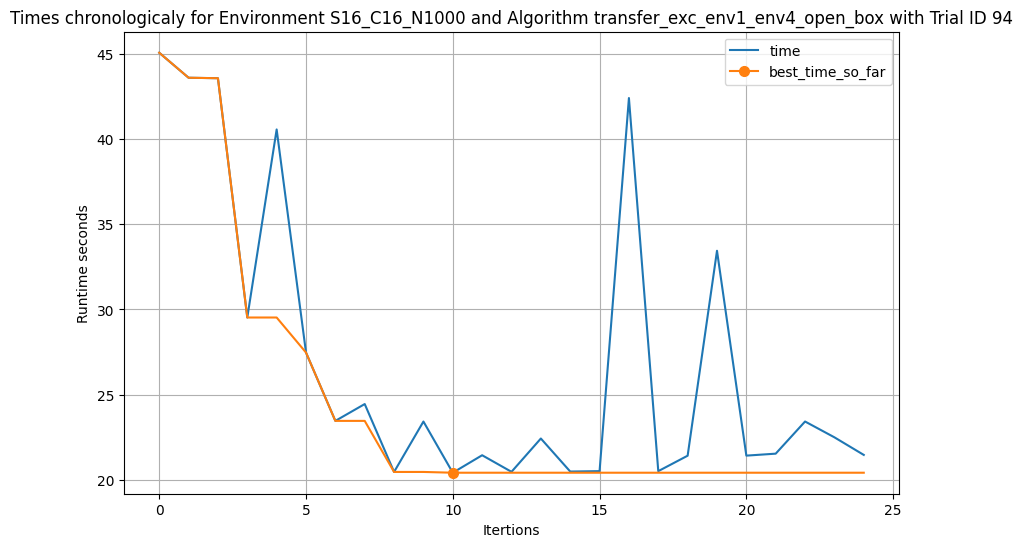

In [2]:
import numpy as np
from scipy.stats import bootstrap
import pandas as pd
import glob
from collections import defaultdict
import typing
import matplotlib.pyplot as plt




trial_id_to_analyze = 94#129#49#152#150
#152
#94 transfer exc 16-16-1000
# 133 / 79 8-1-50 transfer



search_space_size = 174960
confidence_level = 0.95
round_digits = 2
bootstrap_resamples = 100000




#find right file for trial_id

file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results/*/*/*.csv')

env = ""
algo = ""
df_run = None

for file in file_list:
    env = file.split("/")[-1].split("\\")[-3]
    algo = file.split("\\")[-2]

    df_inner = pd.read_csv(file)
    df_inner = df_inner[df_inner['time'].notna()]
    trial_id = int(df_inner['trial_id'].iloc[0])

    if int(trial_id) == int(trial_id_to_analyze):
        df_run = df_inner
        break
    
runtime = df_run['time'].min()
iteration_of_best_runtime = df_run[df_run['time'] == runtime].index.tolist()

df_run['best_time_so_far'] = df_run['time'].cummin()





# Load random sample for that environment :    
                                                                           # use only random sampels to estimae
file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results/*/random*/*.csv')
#file_list = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/results/*/*/*.csv')
grouped_data = defaultdict(list)

# group all samples per environemnt
for file_path in file_list:
    df_inner = pd.read_csv(file_path)
    df_inner = df_inner[df_inner['time'].notna()]
    df_inner['server_cpu'] = df_inner['server_cpu'].astype(int)
    df_inner['client_cpu'] = df_inner['client_cpu'].astype(int)
    df_inner['network'] = df_inner['network'].astype(int)
    
    for combination, group in df_inner.groupby(['server_cpu', 'client_cpu', 'network']):
        grouped_data[combination].append(group)

grouped_data = {comb: pd.concat(frames, ignore_index=True) for comb, frames in grouped_data.items()}

#get the sample for the current environemnt
df_random_samples = grouped_data[tuple([df_run['server_cpu'].iloc[0], df_run['client_cpu'].iloc[0], df_run['network'].iloc[0]])]

# bootsrapping doesnt work if the best runtime is better than all runtimes in the random sample
df_random_samples = pd.concat([df_random_samples,pd.DataFrame({"time":[0]})], ignore_index=True)





#estimate ci with bootstrapping

def compute_percentile_rank(df, runtime):
    samples = df_random_samples['time'].values  
    #print(samples)
    percentile_rank = np.sum(samples <= runtime) / len(samples) * 100
    return percentile_rank

def compute_confidence_interval(df, runtime):
    samples = df_random_samples['time'].values  

    def bootstrap_percentile(data, runtime):
        #print(np.sum(data <= runtime) / len(data))
        return np.sum(data <= runtime) / len(data)

    confidence_interval = bootstrap(
        (samples,), 
        lambda data: bootstrap_percentile(data, runtime),
        confidence_level=confidence_level,
        n_resamples=bootstrap_resamples
    ).confidence_interval
    return confidence_interval

percentile_rank = compute_percentile_rank(df_random_samples, runtime)
confidence_interval = compute_confidence_interval(df_random_samples, runtime)







print("\n")
print(f"Environment : {env}")
print(f"Trial : {trial_id_to_analyze}")
print(f"Algorithm : {algo}")
print(f"Best runtime : {round(runtime,round_digits)} seconds found after {iteration_of_best_runtime} Iterations")
print("\n")
print(f"Estimate based on random sample of size {len(df_random_samples)}, covering {round(((len(df_random_samples)) / search_space_size) * 100,round_digits)}% of the search space ({search_space_size})")
print(f"Percentile rank in samples: {round(percentile_rank,round_digits)}%")
print("\n")
print("Bootstrapping:")
print(f"{confidence_level * 100}% Confidence Interval: [{round(confidence_interval.low*100,round_digits)}%, {round(confidence_interval.high*100,round_digits)}%]")
print(f"With a confidence of {confidence_level * 100}%, the runtime of {round(runtime,round_digits)} seconds is in the top {round(confidence_interval.high* 100,round_digits) } % of conigurations.")

print("\n")

plt.figure(figsize=(10, 6))
plt.plot(df_run['time'],label="time")
plt.plot(df_run['best_time_so_far'],label="best_time_so_far", markevery=iteration_of_best_runtime,marker="o",markersize=7)
plt.xlabel('Itertions')
plt.ylabel('Runtime seconds')
plt.title(f"Times chronologicaly for Environment {env} and Algorithm {algo} with Trial ID {trial_id}")
plt.grid()
plt.legend()
plt.show()

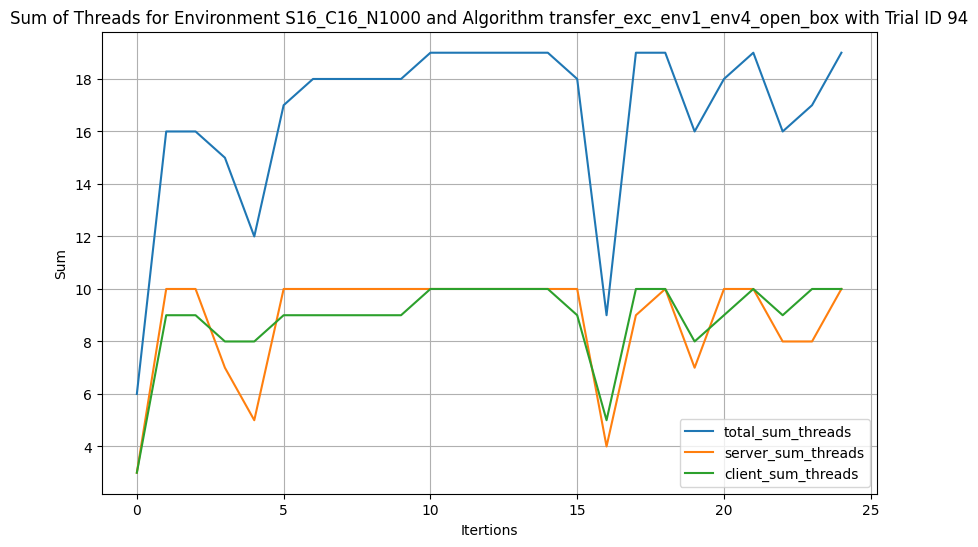

In [5]:
# change of the sum of threads


df_run['total_sum_threads'] = df_run['read_par']+df_run['deser_par']+df_run['comp_par']+df_run['decomp_par']+df_run['deser_par']+df_run['write_par']#+df_run['send_par']+df_run['rcv_par']
df_run['server_sum_threads'] = df_run['deser_par']+df_run['comp_par']+df_run['send_par']#+df_run['read_par']
df_run['client_sum_threads'] = df_run['decomp_par']+df_run['deser_par']+df_run['write_par']#+df_run['rcv_par']


plt.figure(figsize=(10, 6))
plt.plot(df_run['total_sum_threads'],label="total_sum_threads")
plt.plot(df_run['server_sum_threads'],label="server_sum_threads")
plt.plot(df_run['client_sum_threads'],label="client_sum_threads")

plt.xlabel('Itertions')
plt.ylabel('Sum')
plt.title(f"Sum of Threads for Environment {env} and Algorithm {algo} with Trial ID {trial_id}")
plt.grid()
plt.legend()
plt.show()

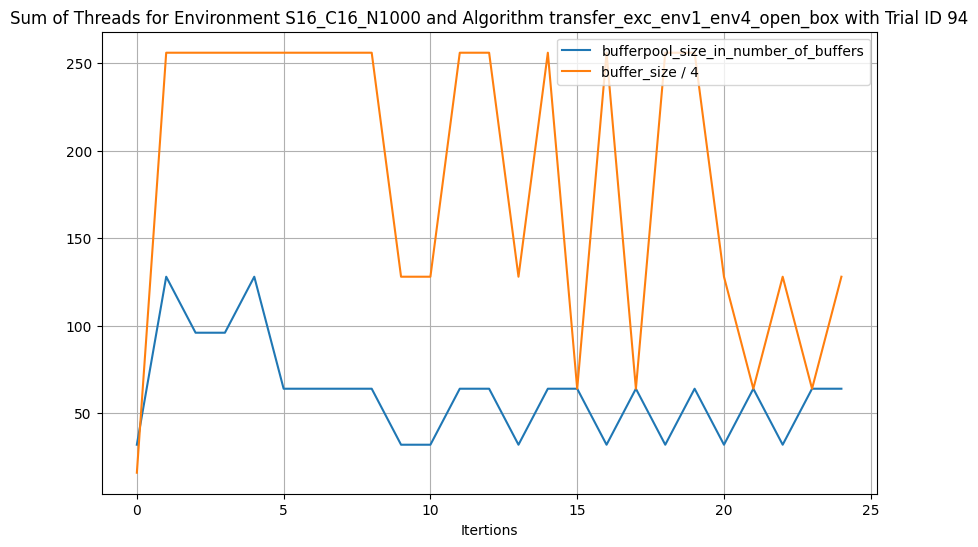

In [15]:


df_run['bufferpool_size_in_number_of_buffers'] = df_run['server_bufferpool_size'] / df_run['buffer_size']

df_run['buffer_size/4'] = df_run['buffer_size'] / 4

plt.figure(figsize=(10, 6))
plt.plot(df_run['bufferpool_size_in_number_of_buffers'],label="bufferpool_size_in_number_of_buffers")
plt.plot(df_run['buffer_size/4'],label="buffer_size / 4")

plt.xlabel('Itertions')
plt.ylabel(' ')
plt.title(f"Sum of Threads for Environment {env} and Algorithm {algo} with Trial ID {trial_id}")
plt.grid()
plt.legend()
plt.show()